# Simulation Study: Open System
 Simulate 50 batches of 5 donors who experience the same Q. Use optimisation of procedure to derive the point estimates for the parameters of the Q governing the system.

In [1]:
### LIBRARY ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as rand

from mm_temptations_functions import *
from scipy.optimize import minimize, Bounds, LinearConstraint

from multiprocess import Pool
from functools import partial

import pickle

In [2]:
planting(456)

In [3]:
# set system wide param
k = 7 # no. of states
timeCourse = 16 # total timepoints
u = [1] * int(timeCourse) # time interval
n_param = int(k/2 * (k-1)) # number of parameters

sampRange_ub = 4
xterm = 1e-15
max_iter = 5e3
numCores = 5
mc_iter = 5

In [4]:
startCount = 10**6 # no. in initial system
N0 = createN0(k, startCount, )

# load Q_true used for closed system
filename = "simResults/simulated_CN_Q_true.pkl"
with open(filename, 'rb') as f:
   Q_true = pickle.load(f)

# closed system w\ noise
simOpen_df = generateAggStates(N0, Q_true, (timeCourse - 1), u=u, recruit=True, timeCount=0, timeMarker='d', noise=True)
simOpen = simOpen_df.to_numpy()

In [5]:
filename = "simDatasets/simulated_Open_dataframe.pkl"
with open(filename, 'wb') as f:
    pickle.dump(simOpen_df, f)

### Estimation

In [6]:
# set variables
pi_hat, T = eqTin(simOpen)

Q_template = make_theta0(k, 'Q')

reg_bounds = def_bounds(n_param, k, account_ingress=False)
reg_con = def_constraints(n_param, k)

In [7]:
# estimate
optimiserArgs = {'costFunc': calc_cost, 'args': (pi_hat, T, k, u, Q_template), 'bounds': reg_bounds, 'constraints': reg_con, 'sampRange_ub': sampRange_ub}
options = {'hessian': None, 'xterm': xterm, 'max_iter': max_iter}

openNoise_theta, openNoise_optError = parallel_mc_optimiser(mc_iter, numCores, n_param, optimiserArgs = optimiserArgs, options = options, progress_bar=True)

Optimisation progress:  [                                                ]   0%


`xtol` termination condition is satisfied.
Number of iterations: 462, function evaluations: 10472, CG iterations: 3367, optimality: 1.98e-10, constraint violation: 0.00e+00, execution time: 4.9e+01 s.


Optimisation progress:  [=========                                       ]  20%


`xtol` termination condition is satisfied.
Number of iterations: 501, function evaluations: 11330, CG iterations: 4027, optimality: 5.66e-11, constraint violation: 0.00e+00, execution time: 5.7e+01 s.


Optimisation progress:  [===================                             ]  40%


`xtol` termination condition is satisfied.
Number of iterations: 662, function evaluations: 15334, CG iterations: 5247, optimality: 2.43e-10, constraint violation: 0.00e+00, execution time: 7e+01 s.


Optimisation progress:  [============================                    ]  60%


The maximum number of function evaluations is exceeded.
Number of iterations: 5000, function evaluations: 117568, CG iterations: 79967, optimality: 3.55e-08, constraint violation: 0.00e+00, execution time: 3.8e+02 s.


Optimisation progress:  [======================================          ]  80%


The maximum number of function evaluations is exceeded.
Number of iterations: 5000, function evaluations: 121814, CG iterations: 64226, optimality: 3.38e-09, constraint violation: 0.00e+00, execution time: 3.9e+02 s.


Optimisation progress:  [================================================] 100%
Optimisation progress:  [================================================] 100%


In [7]:
openNoise_theta - Q_true[Q_true[:,:-1].nonzero()]

NameError: name 'openNoise_theta' is not defined

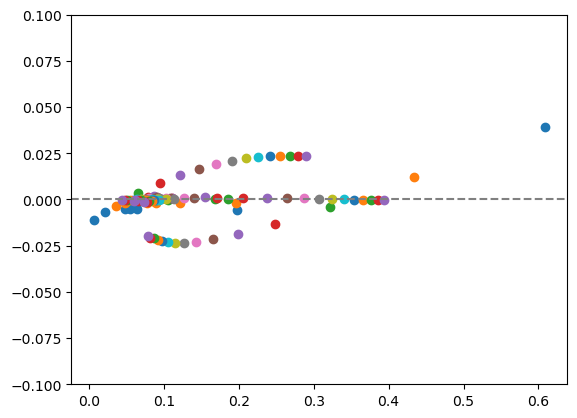

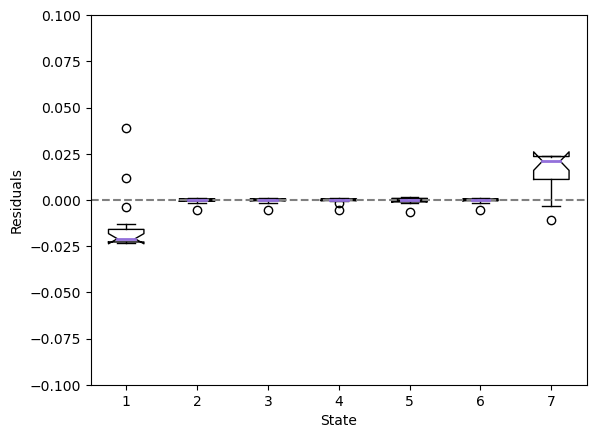

Average abs. residual:  0.006086885552866841


In [18]:
# residuals
new = openNoise_theta
S1_Q = theta_to_Q(new, k,Q_template)

state_list = ['State ' + str(i) for i in range(1,k+1)]

epsi = np.zeros((T-1,k))
pred = np.zeros((k,T))

for i in range(1,T):
    S1_P = transMat(S1_Q, u[i-1])
    pred[:,(i-1)] = np.matmul(S1_P.transpose(),pi_hat[:,(i-1)]) 
    epsi[(i-1),:] = pred[:,(i-1)] - pi_hat[:,i]
    plt.scatter(pred[:,(i-1)], epsi[(i-1),:])

plt.axhline(y=0, linestyle = '--', color = 'grey')
plt.ylim(-1e-1,1e-1)
plt.show() 



plt.boxplot(epsi,
            notch=True,
            medianprops=dict(color="mediumpurple", linewidth=2))
plt.xlabel("State")
plt.ylabel("Residuals")
plt.ylim(-1e-1,1e-1)
plt.axhline(y=0, linestyle = '--', color = 'grey')
plt.show()
        
print("Average abs. residual: ", np.mean(abs(epsi)))

Make loop with 50 iterations for creating multiple donors.

In [8]:

def create_multiDonor_simData(i, donorGroupSize = 5, Q = Q_true, timeCourse = 16):
    planting(i)
    
    startCount = 10**6
    u = [1] * int(timeCourse) # time interval
    
    pi_hat_donors = {}
    T_donors = {}
    u_donors = {}

    donor_list = ['donor_' + str(i) for i in range(1, donorGroupSize+1)]

    for d in donor_list:
        N0 = createN0(k, startCount)
        donor = generateAggStates(N0, Q_true, (timeCourse - 1), u=u, recruit=True, timeCount=0, timeMarker='d', noise=True)
        donor = donor.to_numpy()
        pi_hat, T = eqTin(donor)
        
        pi_hat_donors[d] = pi_hat
        T_donors[d] = T
        u_donors[d] = u

    return pi_hat_donors, T_donors, u_donors

def sim_loop_perDonor_estimate(donorGroupSize = 5, replicates = 50, Q = Q_true, timeCourse = 16):

    k = Q_true.shape[0]
    Q_template = make_theta0(k, 'Q')
    n_param = len(Q_template[:,:-1].nonzero()[0])
    
    reg_bounds = def_bounds(n_param, k, account_ingress=False)
    reg_con = def_constraints(n_param, k)
    
    # initialise estimate dictionary to save to.
    estimated_theta = np.empty((replicates,n_param))
    estimated_cost = np.empty(replicates)

    # def. filenames for saving out data during run
    file_data = "simDatasets/simulated_Open_propDicts_groupSize5.pkl"
    file_result = "simResults/simulated_Open_estimates_50reps.pkl"
     
    optimiserArgs = {'costFunc': calc_cost_donors, 'bounds': reg_bounds, 'constraints': reg_con, 'sampRange_ub': 4}
    options = {'hessian': None, 'xterm': 1e-15, 'max_iter': 1e4}

    # track progress
    i=0
    bar = progressbar.ProgressBar(maxval=replicates, \
    widgets=['Simulation progress:',' ',progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()

    startIteration = 0
    for rep in range(startIteration,replicates):

        # load file if not starting from first replicate.
        if rep == startIteration:
            with open(file_result, 'rb') as f:
                [estimated_theta, estimated_cost] = pickle.load(f)
                        
        pi_hat_donors, T_donors, u_donors = create_multiDonor_simData(rep, donorGroupSize, Q, timeCourse)
        optimiserArgs['args'] = (pi_hat_donors, T_donors, k, u_donors, Q_template)
        
        # save first dataset
        if rep == 0:
            with open(file_data, 'wb') as f:
                pickle.dump([pi_hat_donors, T_donors, u_donors], f)
                
        # estimate
        theta_est, optError = parallel_mc_optimiser(5, 5, n_param, optimiserArgs=optimiserArgs, options=options, progress_bar=False)

        # save out
        estimated_theta[rep,:] = theta_est
        estimated_cost[rep] = optError
        
        with open(file_result, 'wb') as f:
                pickle.dump([estimated_theta, estimated_cost], f)

        i+=1
        bar.update(i)
    bar.finish()

In [9]:
# initialise estimate dictionary to save to.
estimated_theta = np.empty((50,n_param))
estimated_cost = np.empty(50)

with open("simResults/simulated_Open_estimates_50reps.pkl", 'wb') as f:
                pickle.dump([estimated_theta, estimated_cost], f)

In [10]:
sim_loop_perDonor_estimate()

`xtol` termination condition is satisfied.
Number of iterations: 8386, function evaluations: 185284, CG iterations: 15703, optimality: 2.61e-11, constraint violation: 0.00e+00, execution time: 4.6e+03 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 10000, function evaluations: 221540, CG iterations: 77148, optimality: 7.90e-02, constraint violation: 0.00e+00, execution time: 5.1e+03 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 10000, function evaluations: 238150, CG iterations: 149479, optimality: 8.52e-09, constraint violation: 0.00e+00, execution time: 5.4e+03 s.


Simulation progress: [=============================================      ]  90%


`xtol` termination condition is satisfied.
Number of iterations: 941, function evaluations: 22220, CG iterations: 9713, optimality: 2.42e-08, constraint violation: 0.00e+00, execution time: 7.6e+02 s.
`xtol` termination condition is satisfied.
Number of iterations: 938, function evaluations: 23232, CG iterations: 6860, optimality: 7.55e-07, constraint violation: 0.00e+00, execution time: 7.8e+02 s.
`xtol` termination condition is satisfied.
Number of iterations: 997, function evaluations: 26114, CG iterations: 9913, optimality: 2.86e-09, constraint violation: 0.00e+00, execution time: 8.4e+02 s.
`xtol` termination condition is satisfied.
Number of iterations: 1450, function evaluations: 35552, CG iterations: 9468, optimality: 1.53e-07, constraint violation: 0.00e+00, execution time: 9.5e+02 s.
`xtol` termination condition is satisfied.
Number of iterations: 2726, function evaluations: 61556, CG iterations: 6689, optimality: 2.68e-11, constraint violation: 0.00e+00, execution time: 1.1e

Simulation progress: [==============================================     ]  92%


`xtol` termination condition is satisfied.
Number of iterations: 710, function evaluations: 15730, CG iterations: 6753, optimality: 2.24e-10, constraint violation: 0.00e+00, execution time: 2.8e+02 s.
`xtol` termination condition is satisfied.
Number of iterations: 3248, function evaluations: 75526, CG iterations: 51945, optimality: 9.48e-09, constraint violation: 0.00e+00, execution time: 2.4e+03 s.
`xtol` termination condition is satisfied.
Number of iterations: 3717, function evaluations: 85822, CG iterations: 48189, optimality: 1.72e-08, constraint violation: 0.00e+00, execution time: 2.4e+03 s.
`xtol` termination condition is satisfied.
Number of iterations: 3966, function evaluations: 88880, CG iterations: 73498, optimality: 5.89e-09, constraint violation: 0.00e+00, execution time: 2.6e+03 s.
`xtol` termination condition is satisfied.
Number of iterations: 6027, function evaluations: 139722, CG iterations: 34185, optimality: 1.83e-10, constraint violation: 0.00e+00, execution tim

Simulation progress: [===============================================    ]  94%


`xtol` termination condition is satisfied.
Number of iterations: 850, function evaluations: 19140, CG iterations: 9656, optimality: 4.59e-11, constraint violation: 0.00e+00, execution time: 4e+02 s.
`xtol` termination condition is satisfied.
Number of iterations: 1324, function evaluations: 29788, CG iterations: 7878, optimality: 3.14e-10, constraint violation: 0.00e+00, execution time: 6.7e+02 s.
`xtol` termination condition is satisfied.
Number of iterations: 1248, function evaluations: 29810, CG iterations: 14976, optimality: 1.12e-10, constraint violation: 0.00e+00, execution time: 7.3e+02 s.
`xtol` termination condition is satisfied.
Number of iterations: 1499, function evaluations: 35288, CG iterations: 19561, optimality: 1.33e-11, constraint violation: 0.00e+00, execution time: 7.9e+02 s.
`xtol` termination condition is satisfied.
Number of iterations: 2661, function evaluations: 63602, CG iterations: 34675, optimality: 3.65e-09, constraint violation: 0.00e+00, execution time: 1

Simulation progress: [================================================   ]  96%


`xtol` termination condition is satisfied.
Number of iterations: 7610, function evaluations: 168696, CG iterations: 102275, optimality: 6.36e-10, constraint violation: 0.00e+00, execution time: 3.1e+03 s.
`xtol` termination condition is satisfied.
Number of iterations: 8270, function evaluations: 183062, CG iterations: 106021, optimality: 7.63e-11, constraint violation: 0.00e+00, execution time: 3.2e+03 s.
`xtol` termination condition is satisfied.
Number of iterations: 7814, function evaluations: 173954, CG iterations: 102093, optimality: 9.89e-11, constraint violation: 0.00e+00, execution time: 3.3e+03 s.
`xtol` termination condition is satisfied.
Number of iterations: 9828, function evaluations: 217866, CG iterations: 130205, optimality: 7.18e-11, constraint violation: 0.00e+00, execution time: 3.4e+03 s.
`xtol` termination condition is satisfied.
Number of iterations: 5303, function evaluations: 119020, CG iterations: 100673, optimality: 4.69e-09, constraint violation: 0.00e+00, ex

Simulation progress: [=================================================  ]  98%


`xtol` termination condition is satisfied.
Number of iterations: 1467, function evaluations: 34628, CG iterations: 16363, optimality: 7.17e-11, constraint violation: 0.00e+00, execution time: 7.7e+02 s.
`xtol` termination condition is satisfied.
Number of iterations: 2541, function evaluations: 61600, CG iterations: 26411, optimality: 4.03e-11, constraint violation: 0.00e+00, execution time: 1.3e+03 s.
`xtol` termination condition is satisfied.
Number of iterations: 1796, function evaluations: 44440, CG iterations: 19677, optimality: 1.22e-08, constraint violation: 0.00e+00, execution time: 1.3e+03 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 10000, function evaluations: 220286, CG iterations: 14138, optimality: 7.48e-02, constraint violation: 0.00e+00, execution time: 3.4e+03 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 10000, function evaluations: 220154, CG iterations: 21966, optimality: 3.10e-02, constraint vio

Simulation progress: [===================================================] 100%
Simulation progress: [===================================================] 100%


In [12]:
filename = "simResults/simulated_Open_estimates_50reps.pkl"

with open(filename, 'rb') as f:
                [estimated_theta, estimated_cost] = pickle.load(f)

In [16]:
estimated_theta.std(axis=0)

array([0.03419737, 0.0312703 , 0.01075557, 0.01202985, 0.00475755,
       0.01382287, 0.10550322, 0.12182303, 0.01215058, 0.00919247,
       0.01008698, 0.45337805, 0.40913593, 0.02037954, 0.0608167 ,
       0.13268081, 0.13538748, 0.02687472, 0.14700623, 0.0598733 ,
       0.0106873 ])